# Deep Q-Learning Applied to Algorithmic Trading

<a href="https://www.kaggle.com/addarm/unsupervised-learning-as-signals-for-pairs-trading" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

INTRO


This deep learning network was inspired by the paper:
```BibTeX
@article{theate2021application,
  title={An application of deep reinforcement learning to algorithmic trading},
  author={Th{\'e}ate, Thibaut and Ernst, Damien},
  journal={Expert Systems with Applications},
  volume={173},
  pages={114632},
  year={2021},
  publisher={Elsevier}
}
```

In [1]:
import os
import warnings
warnings.filterwarnings("ignore")

IS_KAGGLE = os.getenv('IS_KAGGLE', 'True') == 'True'
if IS_KAGGLE:
    # Kaggle confgs
    print('Running in Kaggle...')
    %pip install scikit-learn
    %pip install tensorflow
    %pip install tqdm
    %pip install matplotlib
    %pip install python-dotenv
    %pip install yfinance
    %pip install pyarrow
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))

    DATA_DIR = "/kaggle/input/DATASET"
else:
    DATA_DIR = "./data/"
    print('Running Local...')

import numpy as np
import yfinance as yf
import pandas as pd
from datetime import datetime
from pandas.tseries.offsets import BDay
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import skew, kurtosis
import pyarrow as pa
import pyarrow.parquet as pq

os.getcwd()

Running Local...


'/mnt/c/Users/adamd/workspace/deep-reinforced-learning'

In [2]:
START_DATE = "2017-01-01"
SPLIT_DATE = '2018-1-1' # Turning point from train to tst
END_DATE = "2019-12-31" # pd.Timestamp(datetime.now() - BDay(1)).strftime('%Y-%m-%d')
DATA_DIR = "./data"
INDEX = "Date"
TICKER_SYMBOLS = [
    'DIA',  # Dow Jones
    'SPY',  # S&P 500
    'QQQ',  # NASDAQ 100
    'EZU',  # FTSE 100
    'EWJ',  # Nikkei 225
    'GOOGL',  # Google
    'AAPL',  # Apple
    'META',  # Facebook
    'AMZN',  # Amazon
    'MSFT',  # Microsoft
    'NOK',  # Nokia
    'PHIA.AS',  # Philips
    'SIE.DE',  # Siemens
    'BIDU',  # Baidu
    'BABA',  # Alibaba
    '0700.HK',  # Tencent
    '6758.T',  # Sony
    'JPM',  # JPMorgan Chase
    'HSBC',  # HSBC
    '0939.HK',  # CCB
    'XOM',  # ExxonMobil
    'TSLA',  # Tesla
    'VOW3.DE',  # Volkswagen
    '7203.T',  # Toyota
    'KO',  # Coca Cola
    'ABI.BR',  # AB InBev
    '2503.T',  # Kirin
]
TICKER_SYMBOLS = ['TSLA']
TARGET = 'TSLA'
INTERVAL = "1d"

MODELS_PATH = './models'
LOGS_PATH = './logs'

CAPITAL = 1000
STATE_LEN = 30
FEES = 0.1 / 100
FEATURES = 4 # 4 dims: HLOC
OBS_SPACE = (STATE_LEN)*FEATURES
ACT_SPACE = 2
EPISODES = 50

# Financial Data

In [3]:
def get_tickerdata(tickers_symbols, start=START_DATE, end=END_DATE, interval=INTERVAL, datadir=DATA_DIR):
    tickers = {}
    earliest_end= datetime.strptime(end,'%Y-%m-%d')
    latest_start = datetime.strptime(start,'%Y-%m-%d')
    os.makedirs(DATA_DIR, exist_ok=True)
    for symbol in tickers_symbols:
        cached_file_path = f"{datadir}/{symbol}-{start}-{end}-{interval}.csv"

        try:
            if os.path.exists(cached_file_path):
                df = pd.read_parquet(cached_file_path)
                df.index = pd.to_datetime(df.index)
                assert len(df) > 0
            else:
                df = yf.download(
                    symbol,
                    start=START_DATE,
                    end=END_DATE,
                    progress=False,
                    interval=INTERVAL,
                )
                assert len(df) > 0
                df.to_parquet(cached_file_path, index=True, compression="snappy")
            min_date = df.index.min()
            max_date = df.index.max()
            nan_count = df["Close"].isnull().sum()
            skewness = round(skew(df["Close"].dropna()), 2)
            kurt = round(kurtosis(df["Close"].dropna()), 2)
            outliers_count = (df["Close"] > df["Close"].mean() + (3 * df["Close"].std())).sum()
            print(
                f"{symbol} => min_date: {min_date}, max_date: {max_date}, kurt:{kurt}, skewness:{skewness}, outliers_count:{outliers_count},  nan_count: {nan_count}"
            )
            tickers[symbol] = df

            if min_date > latest_start:
                latest_start = min_date
            if max_date < earliest_end:
                earliest_end = max_date
        except Exception as e:
            print(f"Error with {symbol}: {e}")

    return tickers, latest_start, earliest_end

tickers, latest_start, earliest_end = get_tickerdata(TICKER_SYMBOLS)
tickers[TARGET]

TSLA => min_date: 2017-01-03 00:00:00, max_date: 2019-12-30 00:00:00, kurt:-0.56, skewness:-0.28, outliers_count:0,  nan_count: 0


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03,14.324000,14.688667,14.064000,14.466000,14.466000,88849500
2017-01-04,14.316667,15.200000,14.287333,15.132667,15.132667,168202500
2017-01-05,15.094667,15.165333,14.796667,15.116667,15.116667,88675500
2017-01-06,15.128667,15.354000,15.030000,15.267333,15.267333,82918500
2017-01-09,15.264667,15.461333,15.200000,15.418667,15.418667,59692500
...,...,...,...,...,...,...
2019-12-23,27.452000,28.134001,27.333332,27.948000,27.948000,199794000
2019-12-24,27.890667,28.364668,27.512667,28.350000,28.350000,120820500
2019-12-26,28.527332,28.898666,28.423332,28.729334,28.729334,159508500


# Trading Environment

In [4]:
from tf_agents.environments import py_environment, utils
from tf_agents.specs import array_spec
from tf_agents.trajectories import time_step as ts
import numpy as np

ACT_LONG = 1
ACT_SHORT = -1
ACT_HOLD = 0


class TradingEnv(py_environment.PyEnvironment):
    """
    A custom trading environment for reinforcement learning, compatible with tf_agents.

    This environment simulates a simple trading scenario where an agent can take one of three actions:
    - Long (buy), Short (sell), or Hold a financial instrument, aiming to maximize profit through trading decisions.

    Parameters:
    - data: DataFrame containing the stock market data.
    - data_dim: Dimension of the data to be used for each observation.
    - money: Initial capital to start trading.
    - stateLength: Number of past observations to consider for the state.
    - transactionCosts: Costs associated with trading actions.
    """

    def __init__(self, data, data_dim, money, stateLength, transactionCosts):
        super(TradingEnv, self).__init__()
        # self.data = self.preprocess_data(data)
        self.data = data
        self.data_dim = data_dim
        self.min_balance = -money//4
        self.initial_balance = money
        self.state_length = stateLength
        self.transaction_cost = transactionCosts
        self._episode_ended = False

        self._action_spec = array_spec.BoundedArraySpec(shape=(), dtype=np.int32, minimum=ACT_SHORT, maximum=ACT_LONG, name='action')
        self._observation_spec = array_spec.BoundedArraySpec(shape=(self.state_length, self.data_dim), dtype=np.float32, name='observation')

        self.reset()

    def preprocess_data(self, df):
        log_returns = np.log(df / df.shift(1))
        normalized_data = (log_returns - log_returns.mean()) / log_returns.std()
        normalized_data.dropna(inplace=True)
        return normalized_data

    def action_spec(self):
        """Provides the specification of the action space."""
        return self._action_spec

    def observation_spec(self):
        """Provides the specification of the observation space."""
        return self._observation_spec

    def _reset(self):
        """Resets the environment state and prepares for a new episode."""
        self.balance = self.initial_balance
        self.position = 0
        self.total_shares = 0
        self.current_step = self.state_length
        self._episode_ended = False
        initial_observation = self._next_observation()
        return ts.restart(initial_observation)

    def _next_observation(self):
        """Generates the next observation based on the current step."""
        if self.current_step + self.state_length > len(self.data):
            padding_rows_needed = max(len(self.data) - (self.current_step + self.state_length), 0)
            frame = self.data.iloc[-self.state_length:] if padding_rows_needed == 0 else self.data.iloc[-padding_rows_needed:]
            padding = np.zeros((padding_rows_needed, self.data_dim))
            obs = np.vstack((padding, frame[['Close', 'Low', 'High', 'Volume']].values))
        else:
            frame = self.data.iloc[self.current_step-self.state_length:self.current_step]
            obs = frame[['Close', 'Low', 'High', 'Volume']].values

        obs = np.array(obs, dtype=np.float32)

        return obs

    def _step(self, action):
        """Executes a trading action and returns the new state of the environment."""
        if self._episode_ended:
            return self.reset()

        current_price = self.data.iloc[self.current_step]['Close']
        self.current_step += 1

        reward = 0

        if action == ACT_SHORT or action == ACT_LONG:
            if self.total_shares > 0:
                self.balance += self.total_shares * current_price * (1 - self.transaction_cost)
                reward = self.balance - self.initial_balance
                self.total_shares = 0

        if action == ACT_LONG:
            self.position = 1
            self.total_shares = self.balance // (current_price * (1 + self.transaction_cost))
            self.balance -= self.total_shares * current_price * (1 + self.transaction_cost)
        elif action == ACT_SHORT:
            self.position = -1

        if self.balance < self.min_balance:
            # bankrupt
            done = True
            reward = -1000
        else:
            done = self.current_step >= len(self.data)
        reward = np.clip(reward, -100, 100)
        if done:
            self._episode_ended = True
            return ts.termination(self._next_observation(), reward)
        else:
            return ts.transition(self._next_observation(), reward, discount=1.0)

    def render(self, mode='human'):
        """Outputs the current state of the environment for visualization."""
        print(f'Step: {self.current_step}, Balance: {self.balance}')

environment = TradingEnv(tickers[TARGET], FEATURES, CAPITAL, STATE_LEN, FEES)
utils.validate_py_environment(environment, episodes=5)

2024-03-09 03:48:17.977953: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-09 03:48:17.978004: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-09 03:48:17.978890: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-09 03:48:17.985005: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-09 03:48:18.826267: W tensorflow/compiler/tf2

In [5]:
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment

tf_env = tf_py_environment.TFPyEnvironment(environment)

print(isinstance(tf_env, tf_environment.TFEnvironment))
print("TimeStep Specs:", tf_env.time_step_spec())
print("Action Specs:", tf_env.action_spec())

True
TimeStep Specs: TimeStep(
{'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'observation': BoundedTensorSpec(shape=(30, 4), dtype=tf.float32, name='observation', minimum=array(-3.4028235e+38, dtype=float32), maximum=array(3.4028235e+38, dtype=float32))})
Action Specs: BoundedTensorSpec(shape=(), dtype=tf.int32, name='action', minimum=array(-1, dtype=int32), maximum=array(1, dtype=int32))


# Deep Q-Network Architecure

## Architecture

2 models:
- Policy Model: This is the primary model that the agent uses to make decisions or select actions based on the current state of the environment. The policy model is actively trained and updated throughout the training process based on the agent's experiences. In real-life applications, after the training phase is complete, the policy model is what gets deployed to make decisions or take actions in the given environment.
- Target Model: The target model is used exclusively during the training phase to provide a stable target for the temporal difference (TD) error calculation, which is crucial for the stability of the Q-learning updates. The target model's weights are periodically synchronized with the policy model's weights but at a much slower rate. This delayed update helps to stabilize the learning process by making the target for the policy updates more consistent across training batches. The target model itself is not used for decision-making or action selection outside of the training context.

Some notes on this 2 model arch:
- Stability/Reducing Temporal Correlations: The agent learns a policy that maps states to actions by using a Q-function. This Q-function estimates the rewards by taking a certain action in a given state. The learning process continuously updates the Q-values based on new experiences. If the Q-function is constantly changing—as it would be when updates are made based on estimates from the same function—it can lead to unstable training dynamics. The estimates can become overly optimistic, and the learning process can diverge.
- Target: The target network is a stable baseline for the policy network to compare against. While the policy network is frequently updated to reflect the latest learning, the target network's weights are updated less frequently. This slower update rate provides a fixed target for the policy network to aim for over multiple iterations, making the learning process more stable.

In practice, the policy network is responsible for selecting actions during training and gameplay. Its weights are regularly updated to reflect the agent's learning. The target network, on the other hand, is used to generate the Q-value targets for the updates of the policy network. Every few steps, the weights from the policy network are copied to the target network, ensuring the target for the updates remains relatively stable but still gradually adapts to the improved policy. The policy model is used both during training (for learning and decision-making) and after training (for decision-making in the deployment environment).

The target model is used during the training process only, to calculate stable target values for updating the policy model.
After training is complete and the model is deployed in a real-world application, only the policy model is used to make decisions or take actions based on the learned policy. The target model's role ends with the completion of the training phase, as its primary purpose is to aid in the convergence and stability of the training process itself.

## DRL Flow

- Initialization: init policy network and the target network with the same architecture but separate parameters.
- Data Preparation: Normalize input data using calculated coefficients to ensure consistency in scale.
- Learning Process:
    -At each training step, observe the current market state and process it through normalization.
    - Select an action using the epsilon-greedy policy (a balance between exploration and exploitation) based on the current state.
    - Execute the selected action in the simulated trading environment, observe the next state, and receive a reward based on the action's outcome.
    - Store the experience (current state, action, reward, next state) in the replay memory.
    - Sample a random batch of past experiences from the replay memory for learning to reduce correlation between consecutive learning steps.
    - Use the policy network to predict Q-values for the current states and the target network to calculate the target Q-values for the next states.
    - Update the policy network by minimizing the difference between its Q-value predictions and the target Q-values using backpropagation.
    - Every few steps, update the target network's parameters with the policy network's parameters to gradually adapt the learning target.
- Evaluation and Adjustment: Periodically test the trained policy network on a separate validation set or environment to evaluate performance.
    -Repeat the learning and evaluation process for many episodes until the policy network stabilizes and performs satisfactorily.
- Application Phase
    - Model Deployment: Deploy the trained policy network in a real-world environment or a simulation that closely mimics real trading conditions.
    - Real-time Operation: Observe the current market state and process it (normalization, etc.) as done during training.
    - Use the trained policy network to select the action that maximizes expected rewards based on the current market state, leaning towards exploitation of the learned policy over exploration. Execute the selected action in the market (buy, sell, hold).
- Continuous Learning:
    - Repeat the learning process with new market data and experiences, possibly in a less frequent, offline manner.
    - Update the policy and target networks as new data becomes available and as the market evolves to maintain or improve performance over time.

In [6]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import Huber
from collections import deque
import random

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)

class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


class DQNModel(Sequential):
    def __init__(self, observation_space, action_space, learning_rate=0.0001, l2_reg=0.01, neurons=32, dropout=0.2, n_layers=5, activation=LeakyReLU(alpha=0.01), kernel_initializer=glorot_uniform(), loss=Huber()):
        super().__init__()

        self.add(Dense(neurons, activation=activation, input_shape=(observation_space,), kernel_regularizer=l2(l2_reg), kernel_initializer=kernel_initializer))

        for _ in range(1, n_layers):
            self.add(Dense(neurons, activation=activation, kernel_regularizer=l2(l2_reg), kernel_initializer=kernel_initializer))
            self.add(BatchNormalization())
            self.add(Dropout(dropout))

        self.add(Dense(action_space, activation='linear', kernel_initializer=kernel_initializer))

        self.optimizer = Adam(learning_rate=learning_rate, clipnorm=1.0)
        self.compile(loss=loss, optimizer=self.optimizer)


class DQNAgent:
    def __init__(self, observation_space, action_space, replay_memory_size=10000, batch_size=64, gamma=0.99, epsilon_start=1.0, epsilon_min=0.01, epsilon_decay=0.995, learning_rate=0.001, target_update_iter=1000):
        self.action_space = action_space
        self.memory = ReplayMemory(replay_memory_size)
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.batch_size = batch_size
        self.target_update_iter = target_update_iter
        self.iteration = 0

        self.policy_model = DQNModel(observation_space, action_space, learning_rate)
        self.target_model = DQNModel(observation_space, action_space, learning_rate)
        self.target_model.set_weights(self.policy_model.get_weights())

        self.callbacks = [
            EarlyStopping(monitor='loss', patience=5, verbose=1, restore_best_weights=True),
            ReduceLROnPlateau(monitor='loss', factor=0.2, patience=3, min_lr=0.0001, verbose=1)
        ]

        self.loss_history = []
        self.rewards_history = []
        self.total_rewards_history = []
        self.epsilon_history = []
        self.action_history = []

    def remember(self, state, action, reward, next_state, done):
        self.memory.push(state, action, reward, next_state, done)
        self.action_history.append(action)

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_space)
        state = np.array(state).flatten()[None, :]

        q_values = self.policy_model.predict(state, verbose=0)
        return np.argmax(q_values[0])

    def replay(self):
        if len(self.memory) < self.batch_size:
            return 0

        batch = self.memory.sample(self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        states = np.array([s.flatten() for s in states])
        next_states = np.array([ns.flatten() for ns in next_states])
        rewards = np.array(rewards)
        dones = np.array(dones)
        actions = np.array(actions)

        next_q_values = self.target_model.predict(next_states, verbose=0)
        max_next_q_values = np.max(next_q_values, axis=1)
        targets = rewards + (1 - dones) * self.gamma * max_next_q_values
        q_values = self.policy_model.predict(states, verbose=0)


        for i, action in enumerate(actions):
            q_values[i, action] = targets[i]

        history = self.policy_model.fit(states, q_values, batch_size=self.batch_size, verbose=0, callbacks=self.callbacks)
        loss = history.history['loss'][0]

        self.loss_history.append(loss)
        self.total_rewards_history.append(np.sum(self.rewards_history))
        self.epsilon_history.append(self.epsilon)
        self.rewards_history = []

        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

        self.iteration += 1
        if self.iteration % self.target_update_iter == 0:
            self.update_target_model()

        return loss

    def reset_episode_stats(self):
        self.total_reward = 0
        self.total_loss = 0
        self.episode_steps = 0


    def adapt_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    def update_target_model(self):
        self.target_model.set_weights(self.policy_model.get_weights())

    def save_model(self, file_name):
        self.policy_model.save(file_name)

    def load_model(self, file_name):
        self.policy_model = load_model(file_name)
        self.target_model.set_weights(self.policy_model.get_weights())

    def plot_history(self):
        # Plotting loss history
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 3, 1)
        plt.plot(self.loss_history)
        plt.title('Loss History')
        plt.xlabel('Episode')
        plt.ylabel('Loss')

        # Plotting rewards history
        plt.subplot(1, 3, 2)
        plt.plot(self.total_rewards_history)
        plt.title('Total Rewards History')
        plt.xlabel('Episode')
        plt.ylabel('Total Rewards')

        # Plotting epsilon history
        plt.subplot(1, 3, 3)
        plt.plot(self.epsilon_history)
        plt.title('Epsilon Decay')
        plt.xlabel('Episode')
        plt.ylabel('Epsilon')

        plt.tight_layout()
        plt.show()

Num GPUs Available:  1


2024-03-09 03:48:24.017329: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-09 03:48:24.053154: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-09 03:48:24.053228: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


# Trading Operations

In [7]:
class TradingSimulator:
    def __init__(self, env, agent, episodes, checkpoint_interval):
        self.env = env
        self.agent = agent
        self.episodes = episodes
        self.checkpoint_interval = checkpoint_interval

    def train(self):
        self.episode_rewards = []
        self.episode_losses = []
        for episode in tqdm(range(0, self.episodes + 1), desc="Training"):
            self.agent.reset_episode_stats()
            time_step = self.env.reset()
            state = time_step.observation
            done = time_step.is_last()
            total_reward = 0
            total_loss = 0

            while not done:
                action = self.agent.act(state)
                time_step = self.env.step(action)
                next_state = time_step.observation
                reward = time_step.reward
                done = time_step.is_last()

                self.agent.remember(state, action, reward, next_state, done)
                if done and self.env.balance < self.env.min_balance:
                    print(f"Episode {episode+1} terminated early due to low balance.")
                loss = self.agent.replay()

                state = next_state
                total_reward += reward
                total_loss += loss

            avg_loss = total_loss / episode if episode > 0 else 0
            self.episode_rewards.append(total_reward)
            self.episode_losses.append(avg_loss)

            if episode > 0 and episode % self.checkpoint_interval == 0:
                self.agent.save_model(f'{MODELS_PATH}/dqn_model_checkpoint_{episode}.h5')
                print(f"\nCheckpoint saved at episode {episode}")

            print(f'\nEpisode {episode}: Total Reward: {total_reward}, Avg Loss: {avg_loss:.4f}, Epsilon: {self.agent.epsilon:.4f}')

            if episode > 0 and episode % self.agent.target_update_iter == 0:
                self.agent.update_target_model()

        self.agent.save_model(f'{MODELS_PATH}/dqn_trained.h5')
        print(f'\nTraining completed. Mean Reward: {np.mean(self.episode_rewards):.4f}, Mean Loss: {np.mean(self.episode_losses):.4f}')

    def validate(self):
        total_rewards = []
        for episode in tqdm(range(1, self.episodes + 1), desc="Validation"):
            self.agent.reset_episode_stats()
            time_step = self.env.reset()
            state = time_step.observation
            done = time_step.is_last()
            total_reward = 0

            while not done:
                action = self.agent.act(state)
                time_step = self.env.step(action)
                next_state = time_step.observation
                reward = time_step.reward
                done = time_step.is_last()

                state = next_state
                total_reward += reward

            total_rewards.append(total_reward)
            print(f'\nValidation Episode: {episode}, Total Reward: {total_reward}')

        avg_reward = np.mean(total_rewards)
        print(f'\nAverage Reward Over Validation Episodes: {avg_reward:.4f}')


    def plot_performance(self):
        """
        Plot the training performance including rewards and losses.
        """
        fig, ax1 = plt.subplots()

        color = 'tab:red'
        ax1.set_xlabel('Iterations')
        ax1.set_ylabel('Total Reward', color=color)
        ax1.plot(self.episode_rewards, color=color)
        ax1.tick_params(axis='y', labelcolor=color)
        ax2 = ax1.twinx()
        color = 'tab:blue'
        ax2.set_ylabel('Average Loss', color=color)
        ax2.plot(self.episode_losses, color=color)
        ax2.tick_params(axis='y', labelcolor=color)
        fig.tight_layout()
        plt.title('Training Performance')
        plt.show()


In [8]:
stock= tickers[TARGET]
train_data = stock[stock.index < pd.to_datetime(SPLIT_DATE)].copy()
test_data = stock[stock.index >= pd.to_datetime(SPLIT_DATE)].copy()

agent = DQNAgent(observation_space=STATE_LEN * FEATURES, action_space=ACT_SPACE)

env = TradingEnv(data=train_data, data_dim=FEATURES, money=CAPITAL, stateLength=STATE_LEN, transactionCosts=FEES)
simulator = TradingSimulator(env, agent, episodes=300, checkpoint_interval=1000)
simulator.train()

2024-03-09 03:48:24.093177: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-09 03:48:24.093275: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-09 03:48:24.093323: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-09 03:48:24.289516: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-09 03:48:24.289681: I external/local_xla/xla/stream_executor


Episode 0: Total Reward: 562.6463732719421, Avg Loss: 0.0000, Epsilon: 0.4529


Training:   1%|          | 2/301 [01:32<3:59:01, 47.97s/it]


Episode 1: Total Reward: 1372.8124139010906, Avg Loss: 324208325.6250, Epsilon: 0.1496


Training:   1%|          | 3/301 [02:26<4:10:27, 50.43s/it]


Episode 2: Total Reward: 1442.4860706329346, Avg Loss: 161063999.2500, Epsilon: 0.0494


Training:   1%|▏         | 4/301 [03:21<4:19:39, 52.46s/it]


Episode 3: Total Reward: 1729.4341878890991, Avg Loss: 106092078.3750, Epsilon: 0.0163


Training:   2%|▏         | 5/301 [04:17<4:24:20, 53.58s/it]


Episode 4: Total Reward: 102.52714249491692, Avg Loss: 64115081.4966, Epsilon: 0.0100


Training:   2%|▏         | 6/301 [05:13<4:28:08, 54.54s/it]


Episode 5: Total Reward: -6860.881042718887, Avg Loss: 1200.9572, Epsilon: 0.0100


Training:   2%|▏         | 7/301 [06:11<4:32:48, 55.67s/it]


Episode 6: Total Reward: -3782.953231394291, Avg Loss: 996.3431, Epsilon: 0.0100


Training:   3%|▎         | 8/301 [07:09<4:35:07, 56.34s/it]


Episode 7: Total Reward: -3498.2162802815437, Avg Loss: 893.6012, Epsilon: 0.0100


Training:   3%|▎         | 9/301 [08:04<4:31:54, 55.87s/it]


Episode 8: Total Reward: -38.84280061721802, Avg Loss: 799.1601, Epsilon: 0.0100


Training:   3%|▎         | 10/301 [09:03<4:35:05, 56.72s/it]


Episode 9: Total Reward: 2999.4739142656326, Avg Loss: 661.6840, Epsilon: 0.0100


Training:   4%|▎         | 11/301 [09:57<4:30:31, 55.97s/it]


Episode 10: Total Reward: 864.4092896580696, Avg Loss: 476.6536, Epsilon: 0.0100


Training:   4%|▍         | 12/301 [10:56<4:34:32, 57.00s/it]


Episode 11: Total Reward: 8154.770029976964, Avg Loss: 410.4219, Epsilon: 0.0100


Training:   4%|▍         | 13/301 [11:53<4:32:31, 56.78s/it]


Episode 12: Total Reward: 4611.470951139927, Avg Loss: 358.6007, Epsilon: 0.0100


Training:   5%|▍         | 14/301 [12:52<4:35:06, 57.52s/it]


Episode 13: Total Reward: 7395.368418931961, Avg Loss: 336.3776, Epsilon: 0.0100


Training:   5%|▍         | 15/301 [13:48<4:32:52, 57.25s/it]


Episode 14: Total Reward: 11447.2470703125, Avg Loss: 359.7701, Epsilon: 0.0100


Training:   5%|▌         | 16/301 [14:47<4:34:29, 57.79s/it]


Episode 15: Total Reward: 5657.642243292183, Avg Loss: 321.5889, Epsilon: 0.0100


Training:   6%|▌         | 17/301 [15:44<4:32:03, 57.48s/it]


Episode 16: Total Reward: 8385.390778541565, Avg Loss: 292.3896, Epsilon: 0.0100


Training:   6%|▌         | 18/301 [16:43<4:33:39, 58.02s/it]


Episode 17: Total Reward: 5214.124269619584, Avg Loss: 256.9663, Epsilon: 0.0100


Training:   6%|▋         | 19/301 [17:42<4:32:59, 58.08s/it]


Episode 18: Total Reward: 88.70697391033173, Avg Loss: 305.5792, Epsilon: 0.0100


Training:   7%|▋         | 20/301 [18:39<4:31:40, 58.01s/it]


Episode 19: Total Reward: 8230.519048213959, Avg Loss: 298.7010, Epsilon: 0.0100


Training:   7%|▋         | 21/301 [19:38<4:31:18, 58.14s/it]


Episode 20: Total Reward: 9876.702193260193, Avg Loss: 264.9965, Epsilon: 0.0100


Training:   7%|▋         | 22/301 [20:36<4:29:44, 58.01s/it]


Episode 21: Total Reward: 7503.4941162467, Avg Loss: 251.2302, Epsilon: 0.0100


Training:   8%|▊         | 23/301 [21:36<4:32:20, 58.78s/it]


Episode 22: Total Reward: 7150.978471755981, Avg Loss: 237.0474, Epsilon: 0.0100


Training:   8%|▊         | 24/301 [22:34<4:29:50, 58.45s/it]


Episode 23: Total Reward: 7192.573064863682, Avg Loss: 267.6966, Epsilon: 0.0100


Training:   8%|▊         | 25/301 [23:33<4:30:11, 58.74s/it]


Episode 24: Total Reward: 6017.053714871407, Avg Loss: 239.2603, Epsilon: 0.0100


Training:   9%|▊         | 26/301 [24:31<4:28:21, 58.55s/it]


Episode 25: Total Reward: 7167.9272128120065, Avg Loss: 219.0421, Epsilon: 0.0100


Training:   9%|▉         | 27/301 [25:31<4:28:21, 58.76s/it]


Episode 26: Total Reward: 7092.746461369097, Avg Loss: 205.6875, Epsilon: 0.0100


Training:   9%|▉         | 28/301 [26:28<4:25:25, 58.34s/it]


Episode 27: Total Reward: 6472.810238361359, Avg Loss: 226.3873, Epsilon: 0.0100


Training:  10%|▉         | 29/301 [27:28<4:26:30, 58.79s/it]


Episode 28: Total Reward: 5091.038327515125, Avg Loss: 229.5185, Epsilon: 0.0100


Training:  10%|▉         | 30/301 [28:24<4:21:54, 57.99s/it]


Episode 29: Total Reward: 5629.5284188091755, Avg Loss: 224.8980, Epsilon: 0.0100


Training:  10%|█         | 31/301 [29:25<4:25:08, 58.92s/it]


Episode 30: Total Reward: 3409.8151726722717, Avg Loss: 202.5380, Epsilon: 0.0100


Training:  11%|█         | 32/301 [30:21<4:20:22, 58.08s/it]


Episode 31: Total Reward: 6608.928705453873, Avg Loss: 202.8264, Epsilon: 0.0100


Training:  11%|█         | 33/301 [31:22<4:23:40, 59.03s/it]


Episode 32: Total Reward: 5320.67119333148, Avg Loss: 212.8640, Epsilon: 0.0100


Training:  11%|█▏        | 34/301 [32:19<4:19:38, 58.35s/it]


Episode 33: Total Reward: 5584.957934319973, Avg Loss: 189.4938, Epsilon: 0.0100


Training:  12%|█▏        | 35/301 [33:20<4:21:49, 59.06s/it]


Episode 34: Total Reward: 5326.43885833025, Avg Loss: 182.6722, Epsilon: 0.0100


Training:  12%|█▏        | 36/301 [34:17<4:17:40, 58.34s/it]


Episode 35: Total Reward: 5649.782253965735, Avg Loss: 168.4281, Epsilon: 0.0100


Training:  12%|█▏        | 37/301 [35:18<4:21:09, 59.36s/it]


Episode 36: Total Reward: 5717.518830679357, Avg Loss: 188.3873, Epsilon: 0.0100


Training:  13%|█▎        | 38/301 [36:17<4:19:20, 59.16s/it]


Episode 37: Total Reward: 5550.921028584242, Avg Loss: 190.3140, Epsilon: 0.0100


Training:  13%|█▎        | 39/301 [37:17<4:19:57, 59.53s/it]


Episode 38: Total Reward: 6610.861620813608, Avg Loss: 179.9638, Epsilon: 0.0100


Training:  13%|█▎        | 40/301 [38:15<4:16:29, 58.96s/it]


Episode 39: Total Reward: 5746.060597866774, Avg Loss: 173.3602, Epsilon: 0.0100


Training:  14%|█▎        | 41/301 [39:14<4:15:45, 59.02s/it]


Episode 40: Total Reward: 6613.263411283493, Avg Loss: 164.7551, Epsilon: 0.0100


Training:  14%|█▍        | 42/301 [40:13<4:13:50, 58.80s/it]


Episode 41: Total Reward: 6640.810638546944, Avg Loss: 183.6956, Epsilon: 0.0100


Training:  14%|█▍        | 43/301 [41:10<4:11:39, 58.52s/it]


Episode 42: Total Reward: 12293.678787231445, Avg Loss: 169.5736, Epsilon: 0.0100


Training:  15%|█▍        | 44/301 [42:10<4:11:44, 58.77s/it]


Episode 43: Total Reward: 10983.38614654541, Avg Loss: 167.3554, Epsilon: 0.0100


Training:  15%|█▍        | 45/301 [43:07<4:09:06, 58.39s/it]


Episode 44: Total Reward: 6376.566504001617, Avg Loss: 160.7084, Epsilon: 0.0100


Training:  15%|█▌        | 46/301 [44:07<4:10:25, 58.92s/it]


Episode 45: Total Reward: 8971.469380378723, Avg Loss: 166.7867, Epsilon: 0.0100


Training:  16%|█▌        | 47/301 [45:04<4:06:32, 58.24s/it]


Episode 46: Total Reward: 6520.403502702713, Avg Loss: 164.0989, Epsilon: 0.0100


Training:  16%|█▌        | 48/301 [46:05<4:08:26, 58.92s/it]


Episode 47: Total Reward: 12784.927047729492, Avg Loss: 150.9338, Epsilon: 0.0100


Training:  16%|█▋        | 49/301 [47:01<4:04:32, 58.23s/it]


Episode 48: Total Reward: 9018.454955101013, Avg Loss: 164.9316, Epsilon: 0.0100


Training:  17%|█▋        | 50/301 [48:02<4:07:11, 59.09s/it]


Episode 49: Total Reward: 6712.575316667557, Avg Loss: 138.1843, Epsilon: 0.0100


Training:  17%|█▋        | 51/301 [48:59<4:03:26, 58.43s/it]


Episode 50: Total Reward: 6714.914027750492, Avg Loss: 158.2782, Epsilon: 0.0100


Training:  17%|█▋        | 52/301 [50:01<4:06:24, 59.37s/it]


Episode 51: Total Reward: 5337.471359312534, Avg Loss: 156.7488, Epsilon: 0.0100


Training:  18%|█▊        | 53/301 [50:58<4:02:35, 58.69s/it]


Episode 52: Total Reward: 6861.053727090359, Avg Loss: 138.8320, Epsilon: 0.0100


Training:  18%|█▊        | 54/301 [52:00<4:05:58, 59.75s/it]


Episode 53: Total Reward: 6608.289267301559, Avg Loss: 129.0883, Epsilon: 0.0100


Training:  18%|█▊        | 55/301 [52:56<4:00:27, 58.65s/it]


Episode 54: Total Reward: 12272.58430480957, Avg Loss: 157.0603, Epsilon: 0.0100


Training:  19%|█▊        | 56/301 [53:59<4:04:18, 59.83s/it]


Episode 55: Total Reward: 5063.143458247185, Avg Loss: 166.0069, Epsilon: 0.0100


Training:  19%|█▉        | 57/301 [54:55<3:59:13, 58.83s/it]


Episode 56: Total Reward: 6528.420318722725, Avg Loss: 148.6644, Epsilon: 0.0100


Training:  19%|█▉        | 58/301 [55:56<4:00:15, 59.32s/it]


Episode 57: Total Reward: 4570.558762937784, Avg Loss: 144.2114, Epsilon: 0.0100


Training:  20%|█▉        | 59/301 [56:53<3:56:16, 58.58s/it]


Episode 58: Total Reward: 13181.978409290314, Avg Loss: 162.2680, Epsilon: 0.0100


Training:  20%|█▉        | 60/301 [57:52<3:56:04, 58.77s/it]


Episode 59: Total Reward: 2042.1731937527657, Avg Loss: 190.1456, Epsilon: 0.0100


Training:  20%|██        | 61/301 [58:49<3:53:22, 58.34s/it]


Episode 60: Total Reward: -2877.658356949687, Avg Loss: 161.3792, Epsilon: 0.0100


Training:  21%|██        | 62/301 [59:49<3:53:53, 58.72s/it]


Episode 61: Total Reward: 11340.963892936707, Avg Loss: 149.6593, Epsilon: 0.0100


Training:  21%|██        | 63/301 [1:00:47<3:52:46, 58.68s/it]


Episode 62: Total Reward: 9703.602093696594, Avg Loss: 177.3581, Epsilon: 0.0100


Training:  21%|██▏       | 64/301 [1:01:46<3:52:17, 58.81s/it]


Episode 63: Total Reward: -2074.319679006934, Avg Loss: 176.6086, Epsilon: 0.0100


Training:  22%|██▏       | 65/301 [1:02:46<3:51:48, 58.93s/it]


Episode 64: Total Reward: 9495.915416300297, Avg Loss: 180.8912, Epsilon: 0.0100


Training:  22%|██▏       | 66/301 [1:03:43<3:48:32, 58.35s/it]


Episode 65: Total Reward: -2262.3082883656025, Avg Loss: 154.7452, Epsilon: 0.0100


Training:  22%|██▏       | 67/301 [1:04:43<3:49:41, 58.90s/it]


Episode 66: Total Reward: 9010.065057516098, Avg Loss: 143.3229, Epsilon: 0.0100


Training:  23%|██▎       | 68/301 [1:05:40<3:46:32, 58.34s/it]


Episode 67: Total Reward: 4618.4027218818665, Avg Loss: 157.2368, Epsilon: 0.0100


Training:  23%|██▎       | 69/301 [1:06:41<3:49:15, 59.29s/it]


Episode 68: Total Reward: 3536.643680602312, Avg Loss: 157.6173, Epsilon: 0.0100


Training:  23%|██▎       | 70/301 [1:07:38<3:44:49, 58.39s/it]


Episode 69: Total Reward: 4780.669723004103, Avg Loss: 142.4921, Epsilon: 0.0100


Training:  24%|██▎       | 71/301 [1:08:38<3:46:41, 59.14s/it]


Episode 70: Total Reward: 2269.104445040226, Avg Loss: 153.3645, Epsilon: 0.0100


Training:  24%|██▍       | 72/301 [1:09:34<3:41:04, 57.92s/it]


Episode 71: Total Reward: 649.7793808914721, Avg Loss: 140.2843, Epsilon: 0.0100


Training:  24%|██▍       | 73/301 [1:10:34<3:43:20, 58.77s/it]


Episode 72: Total Reward: 1403.5159933418036, Avg Loss: 135.4120, Epsilon: 0.0100


Training:  25%|██▍       | 74/301 [1:11:31<3:39:33, 58.03s/it]


Episode 73: Total Reward: -2065.4546249955893, Avg Loss: 149.3189, Epsilon: 0.0100


Training:  25%|██▍       | 75/301 [1:12:31<3:41:08, 58.71s/it]


Episode 74: Total Reward: -2634.07588172704, Avg Loss: 129.0906, Epsilon: 0.0100


Training:  25%|██▌       | 76/301 [1:13:27<3:37:32, 58.01s/it]


Episode 75: Total Reward: -8492.010475799441, Avg Loss: 144.1858, Epsilon: 0.0100


Training:  26%|██▌       | 77/301 [1:14:27<3:38:57, 58.65s/it]


Episode 76: Total Reward: -2867.5975457280874, Avg Loss: 151.3206, Epsilon: 0.0100


Training:  26%|██▌       | 78/301 [1:15:25<3:36:19, 58.20s/it]


Episode 77: Total Reward: -7476.011158466339, Avg Loss: 135.0797, Epsilon: 0.0100


Training:  26%|██▌       | 79/301 [1:16:24<3:36:22, 58.48s/it]


Episode 78: Total Reward: -4295.836868325248, Avg Loss: 133.6588, Epsilon: 0.0100


Training:  27%|██▋       | 80/301 [1:17:21<3:34:02, 58.11s/it]


Episode 79: Total Reward: -7408.699298545718, Avg Loss: 127.0697, Epsilon: 0.0100


Training:  27%|██▋       | 81/301 [1:18:20<3:34:01, 58.37s/it]


Episode 80: Total Reward: -4189.145169854164, Avg Loss: 120.8268, Epsilon: 0.0100


Training:  27%|██▋       | 82/301 [1:19:18<3:33:04, 58.38s/it]


Episode 81: Total Reward: 4323.306148558855, Avg Loss: 124.4530, Epsilon: 0.0100


Training:  28%|██▊       | 83/301 [1:20:18<3:33:22, 58.73s/it]


Episode 82: Total Reward: 3107.1417354820296, Avg Loss: 129.0378, Epsilon: 0.0100


Training:  28%|██▊       | 84/301 [1:21:17<3:32:17, 58.70s/it]


Episode 83: Total Reward: -1444.357456550002, Avg Loss: 133.4030, Epsilon: 0.0100


Training:  28%|██▊       | 85/301 [1:22:15<3:31:19, 58.70s/it]


Episode 84: Total Reward: -77.46198689192533, Avg Loss: 121.1959, Epsilon: 0.0100


Training:  29%|██▊       | 86/301 [1:23:14<3:30:05, 58.63s/it]


Episode 85: Total Reward: 11899.449115753174, Avg Loss: 115.5225, Epsilon: 0.0100


Training:  29%|██▉       | 87/301 [1:24:11<3:28:04, 58.34s/it]


Episode 86: Total Reward: 4502.676717415452, Avg Loss: 150.8577, Epsilon: 0.0100


Training:  29%|██▉       | 88/301 [1:25:11<3:28:23, 58.70s/it]


Episode 87: Total Reward: 1452.8360869437456, Avg Loss: 131.4416, Epsilon: 0.0100


Training:  30%|██▉       | 89/301 [1:26:08<3:25:48, 58.25s/it]


Episode 88: Total Reward: 2570.505976423621, Avg Loss: 112.3685, Epsilon: 0.0100


Training:  30%|██▉       | 90/301 [1:27:07<3:25:44, 58.51s/it]


Episode 89: Total Reward: 2597.991592913866, Avg Loss: 113.6708, Epsilon: 0.0100


Training:  30%|███       | 91/301 [1:28:04<3:22:45, 57.93s/it]


Episode 90: Total Reward: 8601.391791343689, Avg Loss: 119.2703, Epsilon: 0.0100


Training:  31%|███       | 92/301 [1:29:05<3:24:41, 58.77s/it]


Episode 91: Total Reward: 11787.031405448914, Avg Loss: 128.7965, Epsilon: 0.0100


Training:  31%|███       | 93/301 [1:30:01<3:20:51, 57.94s/it]


Episode 92: Total Reward: 8178.762961804867, Avg Loss: 124.4975, Epsilon: 0.0100


Training:  31%|███       | 94/301 [1:31:01<3:22:51, 58.80s/it]


Episode 93: Total Reward: 12161.957109451294, Avg Loss: 111.5662, Epsilon: 0.0100


Training:  32%|███▏      | 95/301 [1:31:57<3:19:02, 57.97s/it]


Episode 94: Total Reward: 11951.249560892582, Avg Loss: 105.8541, Epsilon: 0.0100


Training:  32%|███▏      | 96/301 [1:32:58<3:20:55, 58.81s/it]


Episode 95: Total Reward: 2906.9898504391313, Avg Loss: 128.3352, Epsilon: 0.0100


Training:  32%|███▏      | 97/301 [1:33:53<3:16:14, 57.72s/it]


Episode 96: Total Reward: 11638.741248607635, Avg Loss: 114.8665, Epsilon: 0.0100


Training:  33%|███▎      | 98/301 [1:34:54<3:18:25, 58.65s/it]


Episode 97: Total Reward: 11744.26448392868, Avg Loss: 111.7993, Epsilon: 0.0100


Training:  33%|███▎      | 99/301 [1:35:49<3:13:44, 57.55s/it]


Episode 98: Total Reward: 8383.259311437607, Avg Loss: 108.2373, Epsilon: 0.0100


Training:  33%|███▎      | 100/301 [1:36:50<3:16:02, 58.52s/it]


Episode 99: Total Reward: 11406.249781131744, Avg Loss: 113.2692, Epsilon: 0.0100


Training:  34%|███▎      | 101/301 [1:37:46<3:13:06, 57.93s/it]


Episode 100: Total Reward: 11759.764118671417, Avg Loss: 133.4697, Epsilon: 0.0100


Training:  34%|███▍      | 102/301 [1:38:46<3:14:02, 58.50s/it]


Episode 101: Total Reward: 11419.706958293915, Avg Loss: 108.6843, Epsilon: 0.0100


Training:  34%|███▍      | 103/301 [1:39:45<3:12:58, 58.48s/it]


Episode 102: Total Reward: 8398.828601837158, Avg Loss: 103.5763, Epsilon: 0.0100


Training:  35%|███▍      | 104/301 [1:40:43<3:12:02, 58.49s/it]


Episode 103: Total Reward: 11483.832702159882, Avg Loss: 101.1890, Epsilon: 0.0100


Training:  35%|███▍      | 105/301 [1:41:42<3:10:59, 58.47s/it]


Episode 104: Total Reward: 11819.373969554901, Avg Loss: 122.0770, Epsilon: 0.0100


Training:  35%|███▌      | 106/301 [1:42:41<3:10:25, 58.59s/it]


Episode 105: Total Reward: 6235.7802784740925, Avg Loss: 114.3320, Epsilon: 0.0100


Training:  36%|███▌      | 107/301 [1:43:40<3:10:10, 58.81s/it]


Episode 106: Total Reward: 3692.85695643723, Avg Loss: 107.7623, Epsilon: 0.0100


Training:  36%|███▌      | 108/301 [1:44:37<3:07:25, 58.27s/it]


Episode 107: Total Reward: 3636.323639690876, Avg Loss: 107.0756, Epsilon: 0.0100


Training:  36%|███▌      | 109/301 [1:45:37<3:08:17, 58.84s/it]


Episode 108: Total Reward: 4414.967811822891, Avg Loss: 102.9779, Epsilon: 0.0100


Training:  37%|███▋      | 110/301 [1:46:34<3:05:14, 58.19s/it]


Episode 109: Total Reward: 3750.541396468878, Avg Loss: 119.7751, Epsilon: 0.0100


Training:  37%|███▋      | 111/301 [1:47:34<3:06:36, 58.93s/it]


Episode 110: Total Reward: 7874.149632573128, Avg Loss: 120.3104, Epsilon: 0.0100


Training:  37%|███▋      | 112/301 [1:48:29<3:01:58, 57.77s/it]


Episode 111: Total Reward: 2716.735174998641, Avg Loss: 106.7741, Epsilon: 0.0100


Training:  38%|███▊      | 113/301 [1:49:31<3:04:29, 58.88s/it]


Episode 112: Total Reward: 3190.869407594204, Avg Loss: 96.0203, Epsilon: 0.0100


Training:  38%|███▊      | 114/301 [1:50:26<3:00:17, 57.85s/it]


Episode 113: Total Reward: 1570.9271194934845, Avg Loss: 112.1529, Epsilon: 0.0100


Training:  38%|███▊      | 115/301 [1:51:28<3:03:12, 59.10s/it]


Episode 114: Total Reward: 3860.608375519514, Avg Loss: 107.4934, Epsilon: 0.0100


Training:  39%|███▊      | 116/301 [1:52:24<2:59:05, 58.08s/it]


Episode 115: Total Reward: 11484.18121099472, Avg Loss: 98.8039, Epsilon: 0.0100


Training:  39%|███▉      | 117/301 [1:53:25<3:01:01, 59.03s/it]


Episode 116: Total Reward: 12211.670345306396, Avg Loss: 96.4062, Epsilon: 0.0100


Training:  39%|███▉      | 118/301 [1:54:23<2:58:37, 58.57s/it]


Episode 117: Total Reward: 9635.61416053772, Avg Loss: 96.3971, Epsilon: 0.0100


Training:  40%|███▉      | 119/301 [1:55:23<2:59:13, 59.08s/it]


Episode 118: Total Reward: 10218.923064947128, Avg Loss: 122.1741, Epsilon: 0.0100


Training:  40%|███▉      | 120/301 [1:56:20<2:56:17, 58.44s/it]


Episode 119: Total Reward: 2786.6338469833136, Avg Loss: 108.6020, Epsilon: 0.0100


Training:  40%|████      | 121/301 [1:57:20<2:56:39, 58.88s/it]


Episode 120: Total Reward: 11787.712466716766, Avg Loss: 106.5062, Epsilon: 0.0100


Training:  41%|████      | 122/301 [1:58:16<2:53:24, 58.12s/it]


Episode 121: Total Reward: 12173.523273468018, Avg Loss: 102.4669, Epsilon: 0.0100


Training:  41%|████      | 123/301 [1:59:16<2:54:13, 58.73s/it]


Episode 122: Total Reward: 12430.089714050293, Avg Loss: 104.1435, Epsilon: 0.0100


Training:  41%|████      | 124/301 [2:00:13<2:51:39, 58.19s/it]


Episode 123: Total Reward: -3037.3438808619976, Avg Loss: 105.7092, Epsilon: 0.0100


Training:  42%|████▏     | 125/301 [2:01:12<2:50:51, 58.25s/it]


Episode 124: Total Reward: 10573.019426465034, Avg Loss: 97.1442, Epsilon: 0.0100


Training:  42%|████▏     | 126/301 [2:02:10<2:49:42, 58.19s/it]


Episode 125: Total Reward: 1872.320661664009, Avg Loss: 98.5591, Epsilon: 0.0100


Training:  42%|████▏     | 127/301 [2:03:10<2:50:08, 58.67s/it]


Episode 126: Total Reward: 1920.5810592770576, Avg Loss: 93.5012, Epsilon: 0.0100


Training:  43%|████▎     | 128/301 [2:04:09<2:49:48, 58.89s/it]


Episode 127: Total Reward: -1028.1590598672628, Avg Loss: 157.1489, Epsilon: 0.0100


Training:  43%|████▎     | 129/301 [2:05:06<2:47:37, 58.47s/it]


Episode 128: Total Reward: 12122.56699180603, Avg Loss: 111.3007, Epsilon: 0.0100


Training:  43%|████▎     | 130/301 [2:06:07<2:48:10, 59.01s/it]


Episode 129: Total Reward: 455.8030168861151, Avg Loss: 99.8407, Epsilon: 0.0100


Training:  44%|████▎     | 131/301 [2:07:05<2:46:41, 58.83s/it]


Episode 130: Total Reward: -7491.900584861636, Avg Loss: 96.1545, Epsilon: 0.0100


Training:  44%|████▍     | 132/301 [2:08:06<2:46:59, 59.29s/it]


Episode 131: Total Reward: -9231.955447150394, Avg Loss: 113.7835, Epsilon: 0.0100


Training:  44%|████▍     | 133/301 [2:09:02<2:43:31, 58.40s/it]


Episode 132: Total Reward: 2971.2036959528923, Avg Loss: 112.3683, Epsilon: 0.0100


Training:  45%|████▍     | 134/301 [2:10:03<2:44:48, 59.21s/it]


Episode 133: Total Reward: 172.22774881124496, Avg Loss: 103.1586, Epsilon: 0.0100


Training:  45%|████▍     | 135/301 [2:10:59<2:40:57, 58.18s/it]


Episode 134: Total Reward: 4136.962961614132, Avg Loss: 97.7173, Epsilon: 0.0100


Training:  45%|████▌     | 136/301 [2:12:00<2:42:26, 59.07s/it]


Episode 135: Total Reward: -394.29410752654076, Avg Loss: 97.1130, Epsilon: 0.0100


Training:  46%|████▌     | 137/301 [2:12:56<2:38:46, 58.09s/it]


Episode 136: Total Reward: 9495.490430161357, Avg Loss: 114.3227, Epsilon: 0.0100


Training:  46%|████▌     | 138/301 [2:13:57<2:40:40, 59.14s/it]


Episode 137: Total Reward: -1196.8171030506492, Avg Loss: 106.9813, Epsilon: 0.0100


Training:  46%|████▌     | 139/301 [2:14:55<2:38:28, 58.69s/it]


Episode 138: Total Reward: -1081.8410514295101, Avg Loss: 101.7085, Epsilon: 0.0100


Training:  47%|████▋     | 140/301 [2:15:55<2:38:47, 59.18s/it]


Episode 139: Total Reward: 769.5276571065187, Avg Loss: 99.8147, Epsilon: 0.0100


Training:  47%|████▋     | 141/301 [2:16:54<2:37:10, 58.94s/it]


Episode 140: Total Reward: -8879.62002530694, Avg Loss: 101.5070, Epsilon: 0.0100


Training:  47%|████▋     | 142/301 [2:17:53<2:36:20, 59.00s/it]


Episode 141: Total Reward: -3964.189012646675, Avg Loss: 99.8164, Epsilon: 0.0100


Training:  48%|████▊     | 143/301 [2:18:51<2:35:09, 58.92s/it]


Episode 142: Total Reward: 168.83789286017418, Avg Loss: 94.9619, Epsilon: 0.0100


Training:  48%|████▊     | 144/301 [2:19:50<2:33:52, 58.81s/it]


Episode 143: Total Reward: -1417.3002420067787, Avg Loss: 92.8082, Epsilon: 0.0100


Training:  48%|████▊     | 145/301 [2:20:49<2:33:10, 58.91s/it]


Episode 144: Total Reward: -3142.029653131962, Avg Loss: 89.6975, Epsilon: 0.0100


Training:  49%|████▊     | 146/301 [2:21:49<2:32:54, 59.19s/it]


Episode 145: Total Reward: 522.4379358887672, Avg Loss: 102.4653, Epsilon: 0.0100


Training:  49%|████▉     | 147/301 [2:22:48<2:31:38, 59.08s/it]


Episode 146: Total Reward: -3235.1241550818086, Avg Loss: 93.7577, Epsilon: 0.0100


Training:  49%|████▉     | 148/301 [2:23:46<2:29:37, 58.68s/it]


Episode 147: Total Reward: 1674.7297522425652, Avg Loss: 94.9413, Epsilon: 0.0100


Training:  50%|████▉     | 149/301 [2:24:45<2:29:30, 59.01s/it]


Episode 148: Total Reward: 11232.400212287903, Avg Loss: 92.2334, Epsilon: 0.0100


Training:  50%|████▉     | 150/301 [2:25:42<2:26:53, 58.37s/it]


Episode 149: Total Reward: 9721.62759399414, Avg Loss: 96.5269, Epsilon: 0.0100


Training:  50%|█████     | 151/301 [2:26:43<2:27:42, 59.08s/it]


Episode 150: Total Reward: -1823.7860616445541, Avg Loss: 90.4903, Epsilon: 0.0100


Training:  50%|█████     | 152/301 [2:27:39<2:24:23, 58.15s/it]


Episode 151: Total Reward: -3586.336890205741, Avg Loss: 87.9450, Epsilon: 0.0100


Training:  51%|█████     | 153/301 [2:28:40<2:25:42, 59.07s/it]


Episode 152: Total Reward: 10132.18766155839, Avg Loss: 86.2831, Epsilon: 0.0100


Training:  51%|█████     | 154/301 [2:29:37<2:23:12, 58.45s/it]


Episode 153: Total Reward: -3107.582188293338, Avg Loss: 84.4315, Epsilon: 0.0100


Training:  51%|█████▏    | 155/301 [2:30:39<2:24:30, 59.38s/it]


Episode 154: Total Reward: 178.31143528223038, Avg Loss: 89.6923, Epsilon: 0.0100


Training:  52%|█████▏    | 156/301 [2:31:35<2:21:04, 58.38s/it]


Episode 155: Total Reward: 11911.067942097783, Avg Loss: 83.8031, Epsilon: 0.0100


Training:  52%|█████▏    | 157/301 [2:32:36<2:22:22, 59.32s/it]


Episode 156: Total Reward: 9948.259348779917, Avg Loss: 83.4684, Epsilon: 0.0100


Training:  52%|█████▏    | 158/301 [2:33:32<2:18:41, 58.19s/it]


Episode 157: Total Reward: 11375.791527748108, Avg Loss: 82.3699, Epsilon: 0.0100


Training:  53%|█████▎    | 159/301 [2:34:33<2:20:02, 59.17s/it]


Episode 158: Total Reward: 10132.160400778055, Avg Loss: 79.2945, Epsilon: 0.0100


Training:  53%|█████▎    | 160/301 [2:35:29<2:16:55, 58.26s/it]


Episode 159: Total Reward: 2663.5522006750107, Avg Loss: 88.6115, Epsilon: 0.0100


Training:  53%|█████▎    | 161/301 [2:36:31<2:17:53, 59.10s/it]


Episode 160: Total Reward: 3481.103698089719, Avg Loss: 81.9637, Epsilon: 0.0100


Training:  54%|█████▍    | 162/301 [2:37:27<2:15:20, 58.42s/it]


Episode 161: Total Reward: 10222.005055814981, Avg Loss: 76.5097, Epsilon: 0.0100


Training:  54%|█████▍    | 163/301 [2:38:28<2:15:47, 59.04s/it]


Episode 162: Total Reward: 10039.936414152384, Avg Loss: 81.6196, Epsilon: 0.0100


Training:  54%|█████▍    | 164/301 [2:39:26<2:14:31, 58.91s/it]


Episode 163: Total Reward: 1251.3595589399338, Avg Loss: 157.5695, Epsilon: 0.0100


Training:  55%|█████▍    | 165/301 [2:40:26<2:13:50, 59.05s/it]


Episode 164: Total Reward: 1257.014135479927, Avg Loss: 149.6403, Epsilon: 0.0100


Training:  55%|█████▌    | 166/301 [2:41:24<2:12:18, 58.81s/it]


Episode 165: Total Reward: -2273.26328510046, Avg Loss: 139.5756, Epsilon: 0.0100


Training:  55%|█████▌    | 167/301 [2:42:22<2:10:47, 58.56s/it]


Episode 166: Total Reward: -3613.0916230008006, Avg Loss: 144.2653, Epsilon: 0.0100


Training:  56%|█████▌    | 168/301 [2:43:21<2:09:54, 58.61s/it]


Episode 167: Total Reward: 2350.012841530144, Avg Loss: 123.0605, Epsilon: 0.0100


Training:  56%|█████▌    | 169/301 [2:44:19<2:08:50, 58.57s/it]


Episode 168: Total Reward: -82.72960786893964, Avg Loss: 105.3715, Epsilon: 0.0100


Training:  56%|█████▋    | 170/301 [2:45:19<2:08:28, 58.84s/it]


Episode 169: Total Reward: 2099.3636989742517, Avg Loss: 85.1310, Epsilon: 0.0100


Training:  57%|█████▋    | 171/301 [2:46:16<2:06:11, 58.24s/it]


Episode 170: Total Reward: 3062.5571786165237, Avg Loss: 84.9894, Epsilon: 0.0100


Training:  57%|█████▋    | 172/301 [2:47:16<2:06:31, 58.85s/it]


Episode 171: Total Reward: 2024.8268758058548, Avg Loss: 81.1921, Epsilon: 0.0100


Training:  57%|█████▋    | 173/301 [2:48:13<2:04:41, 58.45s/it]


Episode 172: Total Reward: 2554.1091338396072, Avg Loss: 84.0948, Epsilon: 0.0100


Training:  58%|█████▊    | 174/301 [2:49:14<2:05:24, 59.25s/it]


Episode 173: Total Reward: 2570.415202334523, Avg Loss: 81.5415, Epsilon: 0.0100


Training:  58%|█████▊    | 175/301 [2:50:10<2:02:11, 58.18s/it]


Episode 174: Total Reward: 3088.2734347581863, Avg Loss: 79.1344, Epsilon: 0.0100


Training:  58%|█████▊    | 176/301 [2:51:12<2:03:11, 59.13s/it]


Episode 175: Total Reward: 9439.280153274536, Avg Loss: 78.5009, Epsilon: 0.0100


Training:  59%|█████▉    | 177/301 [2:52:08<2:00:29, 58.30s/it]


Episode 176: Total Reward: 11449.510625958443, Avg Loss: 78.4774, Epsilon: 0.0100


Training:  59%|█████▉    | 178/301 [2:53:10<2:01:44, 59.38s/it]


Episode 177: Total Reward: 9534.480092048645, Avg Loss: 82.2165, Epsilon: 0.0100


Training:  59%|█████▉    | 179/301 [2:54:06<1:58:50, 58.45s/it]


Episode 178: Total Reward: 1437.400047391653, Avg Loss: 77.1727, Epsilon: 0.0100


Training:  60%|█████▉    | 180/301 [2:55:07<1:59:31, 59.27s/it]


Episode 179: Total Reward: 9472.833963394165, Avg Loss: 78.1468, Epsilon: 0.0100


Training:  60%|██████    | 181/301 [2:56:04<1:56:58, 58.48s/it]


Episode 180: Total Reward: 9309.791004180908, Avg Loss: 73.6425, Epsilon: 0.0100


Training:  60%|██████    | 182/301 [2:57:04<1:57:13, 59.11s/it]


Episode 181: Total Reward: 8398.406852722168, Avg Loss: 81.8024, Epsilon: 0.0100


Training:  61%|██████    | 183/301 [2:58:02<1:55:16, 58.62s/it]


Episode 182: Total Reward: 1240.6735301613808, Avg Loss: 76.7131, Epsilon: 0.0100


Training:  61%|██████    | 184/301 [2:59:01<1:54:50, 58.89s/it]


Episode 183: Total Reward: 7217.069261074066, Avg Loss: 74.4436, Epsilon: 0.0100


Training:  61%|██████▏   | 185/301 [3:00:00<1:53:55, 58.92s/it]


Episode 184: Total Reward: 8192.824897766113, Avg Loss: 73.9069, Epsilon: 0.0100


Training:  62%|██████▏   | 186/301 [3:00:59<1:52:59, 58.96s/it]


Episode 185: Total Reward: 9502.791991233826, Avg Loss: 75.9403, Epsilon: 0.0100


Training:  62%|██████▏   | 187/301 [3:01:58<1:51:42, 58.80s/it]


Episode 186: Total Reward: -5361.1789927482605, Avg Loss: 71.3698, Epsilon: 0.0100


Training:  62%|██████▏   | 188/301 [3:02:56<1:50:06, 58.46s/it]


Episode 187: Total Reward: -175.5562349781394, Avg Loss: 65.1891, Epsilon: 0.0100


Training:  63%|██████▎   | 189/301 [3:03:55<1:49:40, 58.75s/it]


Episode 188: Total Reward: 10774.158426970243, Avg Loss: 64.9203, Epsilon: 0.0100


Training:  63%|██████▎   | 190/301 [3:04:54<1:48:37, 58.71s/it]


Episode 189: Total Reward: -8112.873902007937, Avg Loss: 67.4306, Epsilon: 0.0100


Training:  63%|██████▎   | 191/301 [3:05:54<1:48:26, 59.15s/it]


Episode 190: Total Reward: -4869.742982245982, Avg Loss: 109.3271, Epsilon: 0.0100


Training:  64%|██████▍   | 192/301 [3:06:51<1:46:24, 58.57s/it]


Episode 191: Total Reward: -3484.766490340233, Avg Loss: 95.0416, Epsilon: 0.0100


Training:  64%|██████▍   | 193/301 [3:07:52<1:46:30, 59.17s/it]


Episode 192: Total Reward: -6705.729027912021, Avg Loss: 83.5811, Epsilon: 0.0100


Training:  64%|██████▍   | 194/301 [3:08:47<1:43:37, 58.11s/it]


Episode 193: Total Reward: -658.9617418348789, Avg Loss: 82.9656, Epsilon: 0.0100


Training:  65%|██████▍   | 195/301 [3:09:49<1:44:34, 59.20s/it]


Episode 194: Total Reward: 7404.444629669189, Avg Loss: 83.6504, Epsilon: 0.0100


Training:  65%|██████▌   | 196/301 [3:10:45<1:41:42, 58.12s/it]


Episode 195: Total Reward: -2832.964633792639, Avg Loss: 82.6876, Epsilon: 0.0100


Training:  65%|██████▌   | 197/301 [3:11:46<1:42:25, 59.09s/it]


Episode 196: Total Reward: -8571.797819897532, Avg Loss: 80.5566, Epsilon: 0.0100


Training:  66%|██████▌   | 198/301 [3:12:42<1:40:01, 58.26s/it]


Episode 197: Total Reward: -9342.699056074023, Avg Loss: 76.5294, Epsilon: 0.0100


Training:  66%|██████▌   | 199/301 [3:13:43<1:40:25, 59.07s/it]


Episode 198: Total Reward: -4213.226702839136, Avg Loss: 69.6347, Epsilon: 0.0100


Training:  66%|██████▋   | 200/301 [3:14:40<1:38:20, 58.42s/it]


Episode 199: Total Reward: 11109.08751487732, Avg Loss: 70.3563, Epsilon: 0.0100


Training:  67%|██████▋   | 201/301 [3:15:40<1:38:05, 58.85s/it]


Episode 200: Total Reward: 9828.245310783386, Avg Loss: 64.9155, Epsilon: 0.0100


Training:  67%|██████▋   | 202/301 [3:16:38<1:36:27, 58.46s/it]


Episode 201: Total Reward: 12302.069930672646, Avg Loss: 63.7842, Epsilon: 0.0100


Training:  67%|██████▋   | 203/301 [3:17:38<1:36:27, 59.05s/it]


Episode 202: Total Reward: 13095.84455358982, Avg Loss: 64.3051, Epsilon: 0.0100


Training:  68%|██████▊   | 204/301 [3:18:35<1:34:40, 58.56s/it]


Episode 203: Total Reward: 7469.052830435336, Avg Loss: 75.6015, Epsilon: 0.0100


Training:  68%|██████▊   | 205/301 [3:19:35<1:34:23, 59.00s/it]


Episode 204: Total Reward: 12511.543622016907, Avg Loss: 70.6790, Epsilon: 0.0100


Training:  68%|██████▊   | 206/301 [3:20:34<1:33:07, 58.81s/it]


Episode 205: Total Reward: -2973.5139135569334, Avg Loss: 79.0508, Epsilon: 0.0100


Training:  69%|██████▉   | 207/301 [3:21:32<1:31:57, 58.69s/it]


Episode 206: Total Reward: 10746.804441928864, Avg Loss: 64.8734, Epsilon: 0.0100


Training:  69%|██████▉   | 208/301 [3:22:32<1:31:30, 59.04s/it]


Episode 207: Total Reward: 11109.08751487732, Avg Loss: 61.5842, Epsilon: 0.0100


Training:  69%|██████▉   | 209/301 [3:23:29<1:29:40, 58.49s/it]


Episode 208: Total Reward: 11067.638738632202, Avg Loss: 64.9225, Epsilon: 0.0100


Training:  70%|██████▉   | 210/301 [3:24:30<1:29:34, 59.07s/it]


Episode 209: Total Reward: 6710.867305994034, Avg Loss: 61.9630, Epsilon: 0.0100


Training:  70%|███████   | 211/301 [3:25:27<1:27:50, 58.56s/it]


Episode 210: Total Reward: 11674.19437712431, Avg Loss: 58.7634, Epsilon: 0.0100


Training:  70%|███████   | 212/301 [3:26:27<1:27:23, 58.91s/it]


Episode 211: Total Reward: 10975.107599258423, Avg Loss: 61.6131, Epsilon: 0.0100


Training:  71%|███████   | 213/301 [3:27:23<1:25:22, 58.21s/it]


Episode 212: Total Reward: 12539.593803405762, Avg Loss: 60.9043, Epsilon: 0.0100


Training:  71%|███████   | 214/301 [3:28:25<1:25:42, 59.11s/it]


Episode 213: Total Reward: 11199.558950424194, Avg Loss: 60.6678, Epsilon: 0.0100


Training:  71%|███████▏  | 215/301 [3:29:21<1:23:25, 58.20s/it]


Episode 214: Total Reward: 10847.284801483154, Avg Loss: 61.2680, Epsilon: 0.0100


Training:  72%|███████▏  | 216/301 [3:30:22<1:23:37, 59.03s/it]


Episode 215: Total Reward: -763.9016173630953, Avg Loss: 61.7076, Epsilon: 0.0100


Training:  72%|███████▏  | 217/301 [3:31:17<1:21:11, 58.00s/it]


Episode 216: Total Reward: 11375.171194076538, Avg Loss: 67.7920, Epsilon: 0.0100


Training:  72%|███████▏  | 218/301 [3:32:19<1:21:40, 59.04s/it]


Episode 217: Total Reward: 11455.44396756962, Avg Loss: 67.3540, Epsilon: 0.0100


Training:  73%|███████▎  | 219/301 [3:33:14<1:19:21, 58.06s/it]


Episode 218: Total Reward: 11109.08751487732, Avg Loss: 63.7726, Epsilon: 0.0100


Training:  73%|███████▎  | 220/301 [3:34:16<1:19:47, 59.10s/it]


Episode 219: Total Reward: 10474.013251066208, Avg Loss: 63.0658, Epsilon: 0.0100


Training:  73%|███████▎  | 221/301 [3:35:12<1:17:35, 58.19s/it]


Episode 220: Total Reward: 11189.998709321022, Avg Loss: 61.2105, Epsilon: 0.0100


Training:  74%|███████▍  | 222/301 [3:36:12<1:17:19, 58.73s/it]


Episode 221: Total Reward: 10569.41623878479, Avg Loss: 63.9379, Epsilon: 0.0100


Training:  74%|███████▍  | 223/301 [3:37:10<1:16:01, 58.48s/it]


Episode 222: Total Reward: 11102.811094284058, Avg Loss: 63.9859, Epsilon: 0.0100


Training:  74%|███████▍  | 224/301 [3:38:10<1:15:28, 58.82s/it]


Episode 223: Total Reward: 1753.2993475198746, Avg Loss: 57.5619, Epsilon: 0.0100


Training:  75%|███████▍  | 225/301 [3:39:07<1:14:11, 58.57s/it]


Episode 224: Total Reward: 8960.968147993088, Avg Loss: 68.4557, Epsilon: 0.0100


Training:  75%|███████▌  | 226/301 [3:40:08<1:14:01, 59.22s/it]


Episode 225: Total Reward: -2101.638666242361, Avg Loss: 61.5975, Epsilon: 0.0100


Training:  75%|███████▌  | 227/301 [3:41:07<1:12:57, 59.15s/it]


Episode 226: Total Reward: 5653.187355697155, Avg Loss: 63.2942, Epsilon: 0.0100


Training:  76%|███████▌  | 228/301 [3:42:07<1:12:06, 59.26s/it]


Episode 227: Total Reward: 9378.166446328163, Avg Loss: 68.3401, Epsilon: 0.0100


Training:  76%|███████▌  | 229/301 [3:43:05<1:10:50, 59.03s/it]


Episode 228: Total Reward: 1014.3373066186905, Avg Loss: 63.5627, Epsilon: 0.0100


Training:  76%|███████▋  | 230/301 [3:44:03<1:09:23, 58.64s/it]


Episode 229: Total Reward: -2722.0760345994495, Avg Loss: 59.7291, Epsilon: 0.0100


Training:  77%|███████▋  | 231/301 [3:45:04<1:09:17, 59.39s/it]


Episode 230: Total Reward: -3438.91992251575, Avg Loss: 59.1180, Epsilon: 0.0100


Training:  77%|███████▋  | 232/301 [3:46:02<1:07:50, 59.00s/it]


Episode 231: Total Reward: -1345.2069274187088, Avg Loss: 63.0515, Epsilon: 0.0100


Training:  77%|███████▋  | 233/301 [3:47:03<1:07:20, 59.42s/it]


Episode 232: Total Reward: 9346.435864210129, Avg Loss: 60.7162, Epsilon: 0.0100


Training:  78%|███████▊  | 234/301 [3:48:00<1:05:33, 58.71s/it]


Episode 233: Total Reward: 1901.8402599096298, Avg Loss: 61.9987, Epsilon: 0.0100


Training:  78%|███████▊  | 235/301 [3:49:01<1:05:19, 59.39s/it]


Episode 234: Total Reward: 9850.674446821213, Avg Loss: 68.4404, Epsilon: 0.0100


Training:  78%|███████▊  | 236/301 [3:49:58<1:03:37, 58.73s/it]


Episode 235: Total Reward: 1612.5251725912094, Avg Loss: 60.0928, Epsilon: 0.0100


Training:  79%|███████▊  | 237/301 [3:51:00<1:03:36, 59.64s/it]


Episode 236: Total Reward: 7333.065683364868, Avg Loss: 58.9207, Epsilon: 0.0100


Training:  79%|███████▉  | 238/301 [3:51:57<1:01:50, 58.89s/it]


Episode 237: Total Reward: -4657.748568192124, Avg Loss: 57.2438, Epsilon: 0.0100


Training:  79%|███████▉  | 239/301 [3:52:58<1:01:36, 59.62s/it]


Episode 238: Total Reward: -6389.5699335336685, Avg Loss: 56.5898, Epsilon: 0.0100


Training:  80%|███████▉  | 240/301 [3:53:54<59:38, 58.66s/it]  


Episode 239: Total Reward: -585.3595435321331, Avg Loss: 55.9856, Epsilon: 0.0100


Training:  80%|████████  | 241/301 [3:54:56<59:33, 59.55s/it]


Episode 240: Total Reward: -7458.7975984066725, Avg Loss: 62.8279, Epsilon: 0.0100


Training:  80%|████████  | 242/301 [3:55:54<57:55, 58.91s/it]


Episode 241: Total Reward: -2807.0167543292046, Avg Loss: 57.1532, Epsilon: 0.0100


Training:  81%|████████  | 243/301 [3:56:53<57:05, 59.07s/it]


Episode 242: Total Reward: 10883.949143767357, Avg Loss: 57.2318, Epsilon: 0.0100


Training:  81%|████████  | 244/301 [3:57:51<55:51, 58.80s/it]


Episode 243: Total Reward: -5695.56322543323, Avg Loss: 55.9704, Epsilon: 0.0100


Training:  81%|████████▏ | 245/301 [3:58:51<55:11, 59.14s/it]


Episode 244: Total Reward: -5715.730454668403, Avg Loss: 57.4472, Epsilon: 0.0100


Training:  82%|████████▏ | 246/301 [3:59:50<54:15, 59.19s/it]


Episode 245: Total Reward: -1453.9146520197392, Avg Loss: 61.2911, Epsilon: 0.0100


Training:  82%|████████▏ | 247/301 [4:00:49<53:08, 59.04s/it]


Episode 246: Total Reward: -4372.392887033522, Avg Loss: 60.1067, Epsilon: 0.0100


Training:  82%|████████▏ | 248/301 [4:01:49<52:15, 59.17s/it]


Episode 247: Total Reward: -3209.8626928925514, Avg Loss: 57.8435, Epsilon: 0.0100


Training:  83%|████████▎ | 249/301 [4:02:46<50:48, 58.62s/it]


Episode 248: Total Reward: -8300.47064487636, Avg Loss: 55.4953, Epsilon: 0.0100


Training:  83%|████████▎ | 250/301 [4:03:46<50:11, 59.05s/it]


Episode 249: Total Reward: 13047.9250664711, Avg Loss: 65.0894, Epsilon: 0.0100


Training:  83%|████████▎ | 251/301 [4:04:43<48:38, 58.36s/it]


Episode 250: Total Reward: -5701.793092831969, Avg Loss: 59.9585, Epsilon: 0.0100


Training:  84%|████████▎ | 252/301 [4:05:44<48:21, 59.21s/it]


Episode 251: Total Reward: 10459.765193879604, Avg Loss: 59.9409, Epsilon: 0.0100


Training:  84%|████████▍ | 253/301 [4:06:40<46:32, 58.18s/it]


Episode 252: Total Reward: -2731.643578827381, Avg Loss: 55.9357, Epsilon: 0.0100


Training:  84%|████████▍ | 254/301 [4:07:42<46:32, 59.41s/it]


Episode 253: Total Reward: 551.397180378437, Avg Loss: 64.1400, Epsilon: 0.0100


Training:  85%|████████▍ | 255/301 [4:08:37<44:34, 58.15s/it]


Episode 254: Total Reward: 12784.020114421844, Avg Loss: 63.5427, Epsilon: 0.0100


Training:  85%|████████▌ | 256/301 [4:09:39<44:24, 59.22s/it]


Episode 255: Total Reward: 10578.672311782837, Avg Loss: 65.7880, Epsilon: 0.0100


Training:  85%|████████▌ | 257/301 [4:10:35<42:38, 58.16s/it]


Episode 256: Total Reward: -1850.1842458248138, Avg Loss: 58.7673, Epsilon: 0.0100


Training:  86%|████████▌ | 258/301 [4:11:35<42:16, 58.98s/it]


Episode 257: Total Reward: -1646.777414739132, Avg Loss: 58.0733, Epsilon: 0.0100


Training:  86%|████████▌ | 259/301 [4:12:31<40:40, 58.11s/it]


Episode 258: Total Reward: 12983.843914985657, Avg Loss: 60.5398, Epsilon: 0.0100


Training:  86%|████████▋ | 260/301 [4:13:33<40:26, 59.18s/it]


Episode 259: Total Reward: 106.15355479810387, Avg Loss: 59.8055, Epsilon: 0.0100


Training:  87%|████████▋ | 261/301 [4:14:31<39:09, 58.73s/it]


Episode 260: Total Reward: 1266.8174747787416, Avg Loss: 60.0070, Epsilon: 0.0100


Training:  87%|████████▋ | 262/301 [4:15:31<38:21, 59.02s/it]


Episode 261: Total Reward: 11172.196866229177, Avg Loss: 57.9241, Epsilon: 0.0100


Training:  87%|████████▋ | 263/301 [4:16:29<37:14, 58.80s/it]


Episode 262: Total Reward: 12176.063064813614, Avg Loss: 57.1689, Epsilon: 0.0100


Training:  88%|████████▊ | 264/301 [4:17:28<36:15, 58.80s/it]


Episode 263: Total Reward: -2226.453901156783, Avg Loss: 58.8458, Epsilon: 0.0100


Training:  88%|████████▊ | 265/301 [4:18:26<35:08, 58.56s/it]


Episode 264: Total Reward: -4474.496981069446, Avg Loss: 60.5391, Epsilon: 0.0100


Training:  88%|████████▊ | 266/301 [4:19:24<34:09, 58.57s/it]


Episode 265: Total Reward: -4430.350746795535, Avg Loss: 56.0460, Epsilon: 0.0100


Training:  89%|████████▊ | 267/301 [4:20:24<33:19, 58.81s/it]


Episode 266: Total Reward: 6181.813154220581, Avg Loss: 53.3927, Epsilon: 0.0100


Training:  89%|████████▉ | 268/301 [4:21:21<32:10, 58.51s/it]


Episode 267: Total Reward: 14194.752990722656, Avg Loss: 58.2805, Epsilon: 0.0100


Training:  89%|████████▉ | 269/301 [4:22:23<31:40, 59.39s/it]


Episode 268: Total Reward: 3847.94157961756, Avg Loss: 55.4694, Epsilon: 0.0100


Training:  90%|████████▉ | 270/301 [4:23:20<30:24, 58.86s/it]


Episode 269: Total Reward: 12513.06035232544, Avg Loss: 53.7260, Epsilon: 0.0100


Training:  90%|█████████ | 271/301 [4:24:21<29:42, 59.42s/it]


Episode 270: Total Reward: 1432.4423777088523, Avg Loss: 53.8505, Epsilon: 0.0100


Training:  90%|█████████ | 272/301 [4:25:16<28:05, 58.14s/it]


Episode 271: Total Reward: 643.6544831693172, Avg Loss: 53.0890, Epsilon: 0.0100


Training:  91%|█████████ | 273/301 [4:26:17<27:29, 58.90s/it]


Episode 272: Total Reward: 356.6689454615116, Avg Loss: 54.9439, Epsilon: 0.0100


Training:  91%|█████████ | 274/301 [4:27:13<26:04, 57.93s/it]


Episode 273: Total Reward: -5217.946245133877, Avg Loss: 70.0233, Epsilon: 0.0100


Training:  91%|█████████▏| 275/301 [4:28:15<25:37, 59.15s/it]


Episode 274: Total Reward: -2800.5641752928495, Avg Loss: 69.4958, Epsilon: 0.0100


Training:  92%|█████████▏| 276/301 [4:29:10<24:13, 58.12s/it]


Episode 275: Total Reward: 11868.554345428944, Avg Loss: 51.7354, Epsilon: 0.0100


Training:  92%|█████████▏| 277/301 [4:30:12<23:43, 59.29s/it]


Episode 276: Total Reward: -14.533858001232147, Avg Loss: 65.3184, Epsilon: 0.0100


Training:  92%|█████████▏| 278/301 [4:31:09<22:23, 58.42s/it]


Episode 277: Total Reward: -2800.5641752928495, Avg Loss: 77.0274, Epsilon: 0.0100


Training:  93%|█████████▎| 279/301 [4:32:10<21:45, 59.33s/it]


Episode 278: Total Reward: 12917.965526103973, Avg Loss: 63.2484, Epsilon: 0.0100


Training:  93%|█████████▎| 280/301 [4:33:06<20:26, 58.39s/it]


Episode 279: Total Reward: 12626.327147245407, Avg Loss: 60.8704, Epsilon: 0.0100


Training:  93%|█████████▎| 281/301 [4:34:08<19:44, 59.20s/it]


Episode 280: Total Reward: 12283.164599180222, Avg Loss: 62.5299, Epsilon: 0.0100


Training:  94%|█████████▎| 282/301 [4:35:05<18:32, 58.55s/it]


Episode 281: Total Reward: 1773.7222094908357, Avg Loss: 55.8012, Epsilon: 0.0100


Training:  94%|█████████▍| 283/301 [4:36:05<17:43, 59.06s/it]


Episode 282: Total Reward: -662.1789370402694, Avg Loss: 53.9019, Epsilon: 0.0100


Training:  94%|█████████▍| 284/301 [4:37:02<16:33, 58.45s/it]


Episode 283: Total Reward: 162.7405121922493, Avg Loss: 52.9348, Epsilon: 0.0100


Training:  95%|█████████▍| 285/301 [4:38:02<15:42, 58.93s/it]


Episode 284: Total Reward: -2782.9246404767036, Avg Loss: 54.1799, Epsilon: 0.0100


Training:  95%|█████████▌| 286/301 [4:38:59<14:37, 58.49s/it]


Episode 285: Total Reward: -2126.6972202062607, Avg Loss: 57.0633, Epsilon: 0.0100


Training:  95%|█████████▌| 287/301 [4:39:59<13:45, 58.97s/it]


Episode 286: Total Reward: -6673.885903045535, Avg Loss: 57.2803, Epsilon: 0.0100


Training:  96%|█████████▌| 288/301 [4:40:58<12:45, 58.86s/it]


Episode 287: Total Reward: -7953.082410514355, Avg Loss: 55.4139, Epsilon: 0.0100


Training:  96%|█████████▌| 289/301 [4:41:57<11:44, 58.74s/it]


Episode 288: Total Reward: -359.7142912745476, Avg Loss: 52.1103, Epsilon: 0.0100


Training:  96%|█████████▋| 290/301 [4:42:56<10:47, 58.86s/it]


Episode 289: Total Reward: -770.6506208926439, Avg Loss: 51.5542, Epsilon: 0.0100


Training:  97%|█████████▋| 291/301 [4:43:53<09:44, 58.42s/it]


Episode 290: Total Reward: -3009.6157309263945, Avg Loss: 48.4994, Epsilon: 0.0100


Training:  97%|█████████▋| 292/301 [4:44:54<08:51, 59.05s/it]


Episode 291: Total Reward: -5013.797990679741, Avg Loss: 47.9203, Epsilon: 0.0100


Training:  97%|█████████▋| 293/301 [4:45:50<07:46, 58.34s/it]


Episode 292: Total Reward: 10248.129315853119, Avg Loss: 47.0313, Epsilon: 0.0100


Training:  98%|█████████▊| 294/301 [4:46:51<06:53, 59.13s/it]


Episode 293: Total Reward: 10666.53989643231, Avg Loss: 48.2087, Epsilon: 0.0100


Training:  98%|█████████▊| 295/301 [4:47:47<05:48, 58.09s/it]


Episode 294: Total Reward: 11811.482150621712, Avg Loss: 51.2769, Epsilon: 0.0100


Training:  98%|█████████▊| 296/301 [4:48:49<04:55, 59.14s/it]


Episode 295: Total Reward: -6255.620382755995, Avg Loss: 52.0139, Epsilon: 0.0100


Training:  99%|█████████▊| 297/301 [4:49:44<03:52, 58.18s/it]


Episode 296: Total Reward: 8600.654444694519, Avg Loss: 46.4905, Epsilon: 0.0100


Training:  99%|█████████▉| 298/301 [4:50:46<02:57, 59.14s/it]


Episode 297: Total Reward: -3168.872056901455, Avg Loss: 51.5056, Epsilon: 0.0100


Training:  99%|█████████▉| 299/301 [4:51:42<01:56, 58.24s/it]


Episode 298: Total Reward: -1162.2637040317059, Avg Loss: 48.5294, Epsilon: 0.0100


Training: 100%|█████████▉| 300/301 [4:52:44<00:59, 59.25s/it]


Episode 299: Total Reward: -1566.4407758712769, Avg Loss: 46.1528, Epsilon: 0.0100


Training: 100%|██████████| 301/301 [4:53:40<00:00, 58.54s/it]


Episode 300: Total Reward: -2810.0361669510603, Avg Loss: 47.8885, Epsilon: 0.0100

Training completed. Mean Reward: 3963.8509, Mean Loss: 2177793.8570


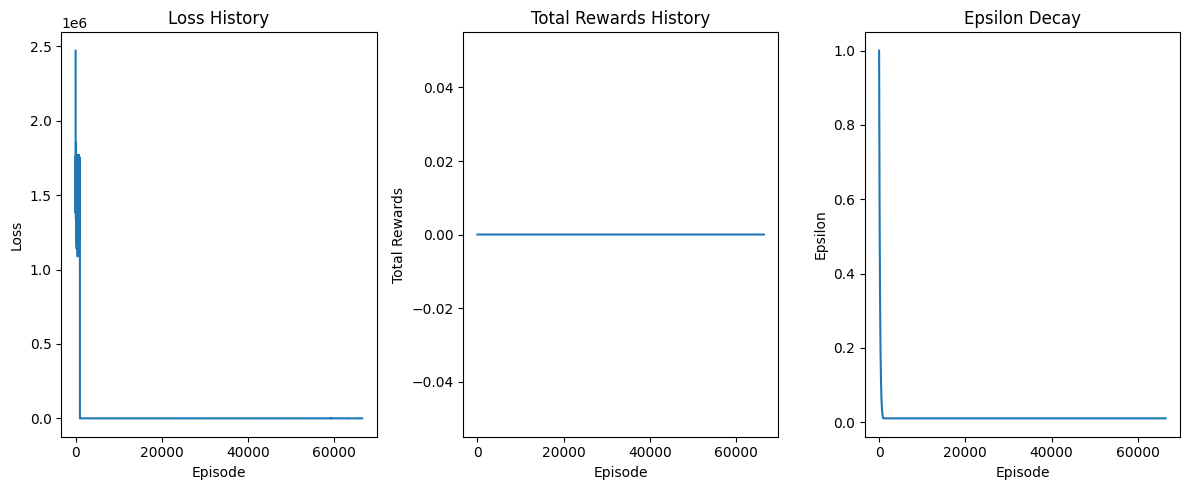

In [9]:
agent.plot_history()

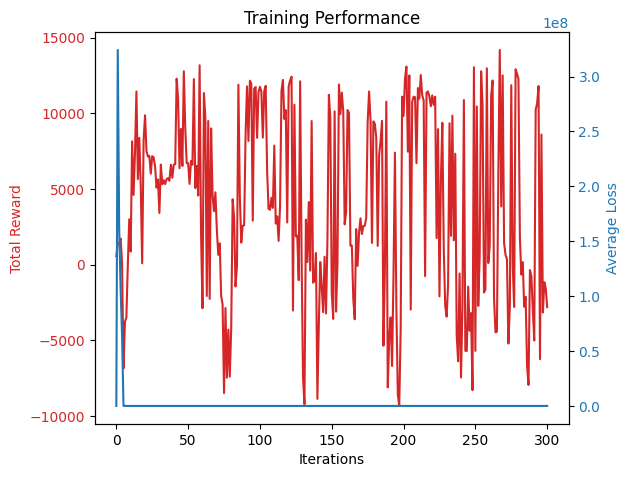

In [10]:
simulator.plot_performance()

In [11]:
env = TradingEnv(data=test_data, data_dim=FEATURES, money=CAPITAL, stateLength=STATE_LEN, transactionCosts=FEES)
simulator = TradingSimulator(env, agent, episodes=30, checkpoint_interval=1000)
simulator.validate()

Validation:   3%|▎         | 1/30 [00:28<13:56, 28.85s/it]


Validation Episode: 1, Total Reward: -43831.33028173447


Validation:   7%|▋         | 2/30 [00:54<12:39, 27.13s/it]


Validation Episode: 2, Total Reward: -43740.33162307739


Validation:  10%|█         | 3/30 [01:21<12:08, 26.98s/it]


Validation Episode: 3, Total Reward: -43740.33162307739


Validation:  13%|█▎        | 4/30 [01:49<11:53, 27.45s/it]


Validation Episode: 4, Total Reward: -43740.33162307739


Validation:  17%|█▋        | 5/30 [02:15<11:08, 26.75s/it]


Validation Episode: 5, Total Reward: -43840.33162307739


Validation:  20%|██        | 6/30 [02:40<10:26, 26.09s/it]


Validation Episode: 6, Total Reward: -43840.33162307739


Validation:  23%|██▎       | 7/30 [03:09<10:23, 27.09s/it]


Validation Episode: 7, Total Reward: -43795.45455265045


Validation:  27%|██▋       | 8/30 [03:35<09:53, 26.96s/it]


Validation Episode: 8, Total Reward: -44786.48363125324


Validation:  30%|███       | 9/30 [04:00<09:10, 26.21s/it]


Validation Episode: 9, Total Reward: -43840.33162307739


Validation:  33%|███▎      | 10/30 [04:28<08:53, 26.69s/it]


Validation Episode: 10, Total Reward: -43740.33162307739


Validation:  37%|███▋      | 11/30 [04:56<08:34, 27.06s/it]


Validation Episode: 11, Total Reward: -43840.33162307739


Validation:  40%|████      | 12/30 [05:21<07:56, 26.45s/it]


Validation Episode: 12, Total Reward: -43665.71352291107


Validation:  43%|████▎     | 13/30 [05:47<07:27, 26.29s/it]


Validation Episode: 13, Total Reward: -43632.287744522095


Validation:  47%|████▋     | 14/30 [06:16<07:13, 27.09s/it]


Validation Episode: 14, Total Reward: -43640.33162307739


Validation:  50%|█████     | 15/30 [06:41<06:40, 26.70s/it]


Validation Episode: 15, Total Reward: -43740.199909210205


Validation:  53%|█████▎    | 16/30 [07:06<06:03, 25.98s/it]


Validation Episode: 16, Total Reward: -43640.33162307739


Validation:  57%|█████▋    | 17/30 [07:34<05:47, 26.76s/it]


Validation Episode: 17, Total Reward: -43840.33162307739


Validation:  60%|██████    | 18/30 [15:58<34:02, 170.19s/it]


Validation Episode: 18, Total Reward: -43940.33162307739


Validation:  63%|██████▎   | 19/30 [16:23<23:12, 126.59s/it]


Validation Episode: 19, Total Reward: -43740.33162307739


Validation:  67%|██████▋   | 20/30 [16:50<16:04, 96.47s/it] 


Validation Episode: 20, Total Reward: -43840.33162307739


Validation:  70%|███████   | 21/30 [17:18<11:25, 76.14s/it]


Validation Episode: 21, Total Reward: -43640.33162307739


Validation:  73%|███████▎  | 22/30 [17:45<08:09, 61.24s/it]


Validation Episode: 22, Total Reward: -43840.33162307739


Validation:  77%|███████▋  | 23/30 [18:10<05:53, 50.44s/it]


Validation Episode: 23, Total Reward: -43640.33162307739


Validation:  80%|████████  | 24/30 [18:39<04:23, 43.96s/it]


Validation Episode: 24, Total Reward: -43940.33162307739


Validation:  83%|████████▎ | 25/30 [19:06<03:14, 38.97s/it]


Validation Episode: 25, Total Reward: -43729.31610298157


Validation:  87%|████████▋ | 26/30 [19:31<02:18, 34.66s/it]


Validation Episode: 26, Total Reward: -43840.33162307739


Validation:  90%|█████████ | 27/30 [19:57<01:36, 32.20s/it]


Validation Episode: 27, Total Reward: -43840.33162307739


Validation:  93%|█████████▎| 28/30 [20:26<01:02, 31.12s/it]


Validation Episode: 28, Total Reward: -43840.33162307739


Validation:  97%|█████████▋| 29/30 [20:53<00:30, 30.04s/it]


Validation Episode: 29, Total Reward: -43740.33162307739


Validation: 100%|██████████| 30/30 [21:19<00:00, 42.64s/it]


Validation Episode: 30, Total Reward: -43940.33162307739

Average Reward Over Validation Episodes: -43813.6138


# Conclusion

CONCLUDE

## References

- [TensorFlow Agents](https://www.tensorflow.org/agents/overview)
- [Open Gym AI Github](https://github.com/openai/gym)
- [Greg et al, OpenAI Gym, (2016)](https://arxiv.org/abs/1606.01540)
- [Théate, Thibaut, and Damien Ernst. "An application of deep reinforcement learning to algorithmic trading." Expert Systems with Applications 173 (2021): 114632.](https://www.sciencedirect.com/science/article/pii/S0957417421000737)
- [Remote development in WSL](https://code.visualstudio.com/docs/remote/wsl-tutorial)
- [NVIDIA Driver Downloads](https://www.nvidia.com/Download/index.aspx)
- [CUDA Toolkit](https://developer.nvidia.com/cuda-toolkit-archive)
- [TensorRT for CUDA](https://docs.nvidia.com/deeplearning/tensorrt/archives/index.html#trt_7)

## Github

Article here is also available on [Github](https://github.com/adamd1985/pairs_trading_unsupervised_learning)

Kaggle notebook available [here](https://www.kaggle.com/code/addarm/unsupervised-learning-as-signals-for-pairs-trading)

## Media

All media used (in the form of code or images) are either solely owned by me, acquired through licensing, or part of the Public Domain and granted use through Creative Commons License.

## CC Licensing and Use

<a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.